# Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda, Concatenate, Conv1D, Reshape, Dropout, LSTM
from tensorflow.keras.losses import MSE, MAPE, MAE
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

model_name = f'model.h5'
brownian_path = f'brownian.npy'

# Loading Data

In [2]:
df = pd.read_csv("tesla.csv")
adj_close = df['Adj Close']
data_np = adj_close.to_numpy()
data_np = data_np.reshape(-1, 1)
data_np.shape

(1342, 1)

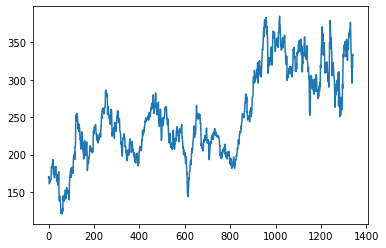

In [3]:
plt.plot(data_np)

# Splitting Data

In [4]:
n1 = int(data_np.shape[0] * 0.8)
n2 = int((data_np.shape[0] - n1)/2)
x_train = data_np[:n1]
x_val = data_np[n1: n1 + n2]
x_test = data_np[n1 + n2:]

minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
x_train_n = minmax_scale.transform(x_train)
x_val_n = minmax_scale.transform(x_val)
x_test_n = minmax_scale.transform(x_test)

# Slicing Data

In [5]:
def slicing(x, history_points):
    sliced_data = np.array([x[i  : i + history_points] for i in range(len(x) - history_points)])
    sliced_data = sliced_data.reshape(-1, history_points, 1)
    labels = sliced_data
    
    return sliced_data, labels


history_points = 100
x_train_n, y_train = slicing(x_train_n, history_points)
x_val_n, y_val = slicing(x_val_n, history_points)
x_test_n, y_test = slicing(x_test_n, history_points)

In [6]:
batch_size = 15

train_size = 50*batch_size
val_size = 2*batch_size
test_size = 2*batch_size

x_train_n = x_train_n[:train_size]
y_train = y_train[:train_size]


x_val_n = x_val_n[:val_size]
y_val = y_val[:val_size]


x_test_n = x_test_n[:test_size]
y_test = y_test[:test_size]

print('number of training samples : ', x_train_n.shape[0])
print('number of validating samples : ', x_val_n.shape[0])
print('number of testing samples : ', x_test_n.shape[0])

number of training samples :  750
number of validating samples :  30
number of testing samples :  30


# Functions to build Geometric Brownian Layer in Keras

In [7]:
def get_s0(price):
    return price[:, :1]

def GBM_tf(s0, mu, sigma, W, N):    
    t = tf.linspace(0., 1., N)
    new_serie = []
    new_serie.append(s0)
    for i in range(N-1):
        drift = (mu - 0.5 * sigma**2) * t[i +1]
        diffusion = sigma * W[i]
        S_temp = s0 * tf.exp(drift + diffusion)
        new_serie.append(S_temp)        
    new_serie = tf.convert_to_tensor(new_serie)
    return new_serie

def GBM_layer(params):
    N = history_points
    s_0 = params[:, 0]
    number_series = batch_size
    mu = params[:, 1]
    sigma = params[:, 2]
    S = []
    for i in range(number_series):
        new_S = GBM_tf(s_0[i], mu[i], sigma[i], new_W, N)
        S.append(new_S)
    S = tf.stack(S, axis = 0)    
    return S

# Loading the Brownian Motion

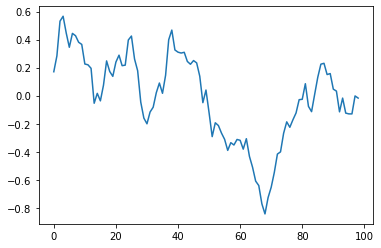

In [8]:
W = np.load(brownian_path)
new_W = tf.convert_to_tensor(W)
plt.plot(W)

# Building the model

In [9]:
input_layer = Input(shape=(history_points, 1), name='input_layer')
f = Reshape((history_points,))(input_layer)
s_0 = Lambda(get_s0)(f)
x = Flatten()(input_layer)
x = Dense(70, activation = 'relu')(x)
x = Dense(50, activation = 'relu')(x)
x = Dense(30, activation = 'relu')(x)
x = Dense(10, activation = 'relu')(x)
x = Dense(5, activation = 'relu')(x)
parameters = Dense(2, name = 'parameters')(x)
params = Concatenate(axis=-1)([s_0, parameters])
output_layer = Lambda(GBM_layer, name='gbm_layer')(params)
model = Model(inputs=input_layer, outputs=output_layer, name = 'Deep-GBM')

In [10]:
model.summary()

Model: "Deep-GBM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           input_layer[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 70)           7070        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           3550        dense[0][0]                      
___________________________________________________________________________________________

In [11]:
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse')

In [16]:
mcp_save = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
hist = model.fit(x=x_train_n, y=y_train, batch_size=batch_size, epochs=50, shuffle=True, validation_data=(x_val_n, y_val), callbacks=[mcp_save])

Train on 750 samples, validate on 30 samples
Epoch 1/50
750/750 [==============================] - 75s 99ms/sample - loss: 0.0178 - val_loss: 0.0124
Epoch 2/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.0092
Epoch 3/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0078
Epoch 4/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0070
Epoch 5/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0066
Epoch 6/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0066
Epoch 7/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0074
Epoch 8/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0069
Epoch 9/50
750/750 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0064
Epoch 10/50
750/750 [==============

In [12]:
model.load_weights(model_name)

In [13]:
model.evaluate(x_test_n, y_test, batch_size=batch_size)

30/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 18s 598ms/sample - loss: 0.0242


0.02108109137043357

Text(0, 0.5, 'Loss')

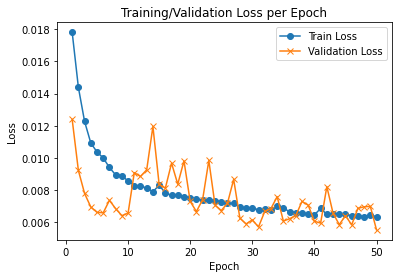

In [18]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Functions to build geometric Brownian motion model

In [13]:
def daily_return(adj_close):
    returns = []
    for i in range(0, len(adj_close)-1):
        today = adj_close[i+1]
        yesterday = adj_close[i]
        daily_return = (today - yesterday)/yesterday
        returns.append(daily_return)
    return returns

def GBM(So, mu, sigma, W, N):    
    t = np.linspace(0.,1.,int(N+1))
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S

###  Simulating for the first time using the Deep-GBM model   ###

In [14]:
x_test_real, y_test_real = slicing(x_test, history_points)
y_test_predicted_1 = model.predict(x_test_n,batch_size=batch_size)
y_test_predicted_1_scaled = minmax_scale.inverse_transform(y_test_predicted_1)

In [15]:
# choose a sample from test data
n = 10
y_true = y_test_real[n][:,0]
y_pred_1 = y_test_predicted_1_scaled[n]

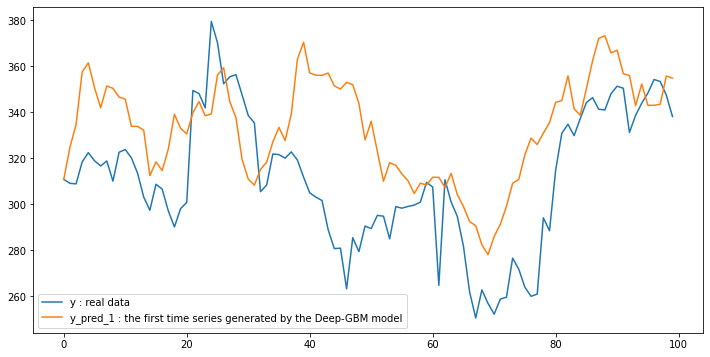

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.legend()

###  Simulating for the first time using the GBM model   ###

In [17]:
returns = daily_return(y_true)

mu = np.mean(returns)*252.           # drift coefficient
sig = np.std(returns)*np.sqrt(252.)  # diffusion coefficient

N = history_points - 1
So = y_true[0]
y_gbm_1 = GBM(So, mu, sig, W, N)

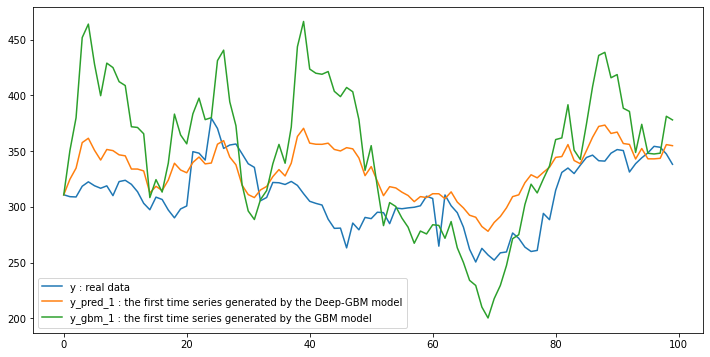

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.plot(y_gbm_1, label = 'y_gbm_1 : the first time series generated by the GBM model')
plt.legend()

###  Simulating for the second time using the Deep-GBM model   ###

In [19]:
x_test_n_2 = np.expand_dims(y_test_predicted_1, axis=2)
y_test_predicted_2 = model.predict(x_test_n_2,batch_size=batch_size)
y_test_predicted_2_scaled = minmax_scale.inverse_transform(y_test_predicted_2)
y_pred_2 = y_test_predicted_2_scaled[n]

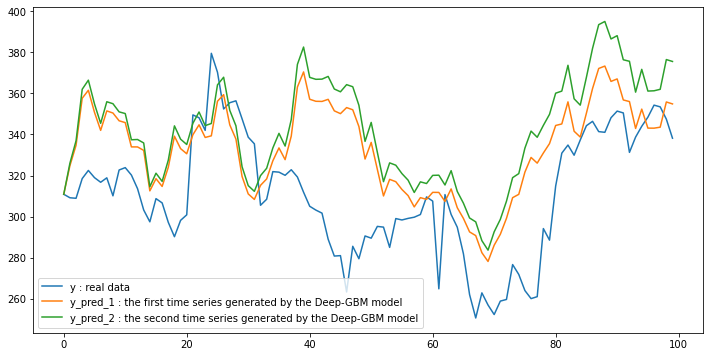

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.plot(y_pred_2, label = 'y_pred_2 : the second time series generated by the Deep-GBM model')
plt.legend()

###  Simulating for the second time using the GBM model   ###

In [21]:
returns = daily_return(y_gbm_1)

mu = np.mean(returns)*252.           # drift coefficient
sig = np.std(returns)*np.sqrt(252.)  # diffusion coefficient

N = history_points - 1
So = y_true[0]
y_gbm_2 = GBM(So, mu, sig, W, N)

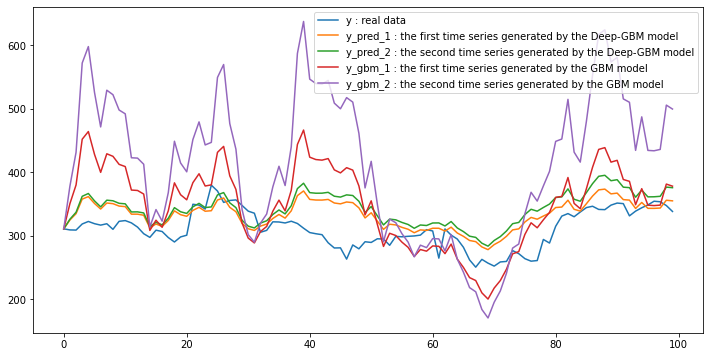

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.plot(y_pred_2, label = 'y_pred_2 : the second time series generated by the Deep-GBM model')
plt.plot(y_gbm_1, label = 'y_gbm_1 : the first time series generated by the GBM model')
plt.plot(y_gbm_2, label = 'y_gbm_2 : the second time series generated by the GBM model')
plt.legend()

###  Simulating for the third time using the Deep-GBM model   ###

In [23]:
x_test_n_3 = np.expand_dims(y_test_predicted_2, axis=2)
y_test_predicted_3 = model.predict(x_test_n_3,batch_size=batch_size)
y_test_predicted_3_saled = minmax_scale.inverse_transform(y_test_predicted_3)
y_pred_3 = y_test_predicted_3_saled[n]

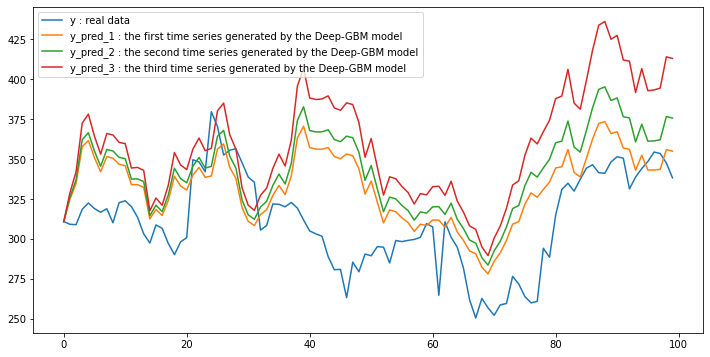

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.plot(y_pred_2, label = 'y_pred_2 : the second time series generated by the Deep-GBM model')
plt.plot(y_pred_3, label = 'y_pred_3 : the third time series generated by the Deep-GBM model')
plt.legend()

###  Simulating for the third time using the GBM model   ###

In [25]:
returns = daily_return(y_gbm_2)

mu = np.mean(returns)*252.           # drift coefficient
sig = np.std(returns)*np.sqrt(252.)  # diffusion coefficient

N = history_points - 1
So = y_true[0]
y_gbm_3 = GBM(So, mu, sig, W, N)

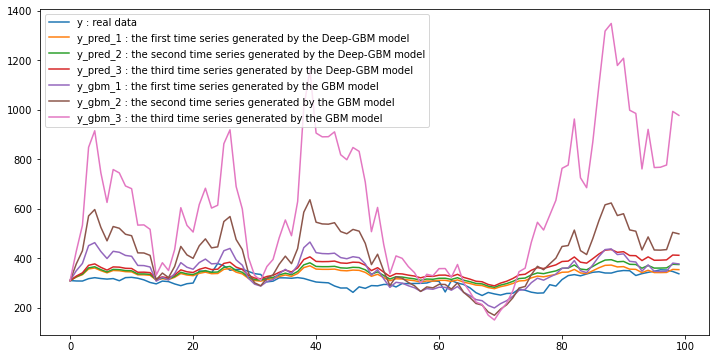

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label = 'y : real data')
plt.plot(y_pred_1, label = 'y_pred_1 : the first time series generated by the Deep-GBM model')
plt.plot(y_pred_2, label = 'y_pred_2 : the second time series generated by the Deep-GBM model')
plt.plot(y_pred_3, label = 'y_pred_3 : the third time series generated by the Deep-GBM model')
plt.plot(y_gbm_1, label = 'y_gbm_1 : the first time series generated by the GBM model')
plt.plot(y_gbm_2, label = 'y_gbm_2 : the second time series generated by the GBM model')
plt.plot(y_gbm_3, label = 'y_gbm_3 : the third time series generated by the GBM model')
plt.legend()

# MSE results

In [27]:
print(MSE(y_true, y_pred_1))
print(MSE(y_true, y_pred_2))
print(MSE(y_true, y_pred_3))
print(MSE(y_true, y_gbm_1))
print(MSE(y_true, y_gbm_2))
print(MSE(y_true, y_gbm_3))
print(MSE(y_pred_1, y_pred_2))
print(MSE(y_pred_2, y_pred_3))
print(MSE(y_gbm_1, y_gbm_2))
print(MSE(y_gbm_2, y_gbm_3))

tf.Tensor(1075.1873, shape=(), dtype=float32)
tf.Tensor(1635.5841, shape=(), dtype=float32)
tf.Tensor(3211.1362, shape=(), dtype=float32)
tf.Tensor(4132.702947245155, shape=(), dtype=float64)
tf.Tensor(19639.66809910033, shape=(), dtype=float64)
tf.Tensor(159511.50012162514, shape=(), dtype=float64)
tf.Tensor(118.68499, shape=(), dtype=float32)
tf.Tensor(373.30585, shape=(), dtype=float32)
tf.Tensor(6554.756799431571, shape=(), dtype=float64)
tf.Tensor(71146.87113639721, shape=(), dtype=float64)


# MAE results

In [28]:
print(MAE(y_true, y_pred_1))
print(MAE(y_true, y_pred_2))
print(MAE(y_true, y_pred_3))
print(MAE(y_true, y_gbm_1))
print(MAE(y_true, y_gbm_2))
print(MAE(y_true, y_gbm_3))
print(MAE(y_pred_1, y_pred_2))
print(MAE(y_pred_2, y_pred_3))
print(MAE(y_gbm_1, y_gbm_2))
print(MAE(y_gbm_2, y_gbm_3))

tf.Tensor(26.432756, shape=(), dtype=float32)
tf.Tensor(34.17657, shape=(), dtype=float32)
tf.Tensor(49.52063, shape=(), dtype=float32)
tf.Tensor(50.763724756139815, shape=(), dtype=float64)
tf.Tensor(113.39555956934633, shape=(), dtype=float64)
tf.Tensor(312.7797358588943, shape=(), dtype=float64)
tf.Tensor(9.417919, shape=(), dtype=float32)
tf.Tensor(16.471767, shape=(), dtype=float32)
tf.Tensor(64.86960994826467, shape=(), dtype=float64)
tf.Tensor(205.03856766461718, shape=(), dtype=float64)


# MAPE results

In [29]:
print(MAPE(y_true, y_pred_1))
print(MAPE(y_true, y_pred_2))
print(MAPE(y_true, y_pred_3))
print(MAPE(y_true, y_gbm_1))
print(MAPE(y_true, y_gbm_2))
print(MAPE(y_true, y_gbm_3))
print(MAPE(y_pred_1, y_pred_2))
print(MAPE(y_pred_2, y_pred_3))
print(MAPE(y_gbm_1, y_gbm_2))
print(MAPE(y_gbm_2, y_gbm_3))

tf.Tensor(8.915666, shape=(), dtype=float32)
tf.Tensor(11.449338, shape=(), dtype=float32)
tf.Tensor(16.36517, shape=(), dtype=float32)
tf.Tensor(16.539230384860247, shape=(), dtype=float64)
tf.Tensor(36.16788977790341, shape=(), dtype=float64)
tf.Tensor(98.18084863424984, shape=(), dtype=float64)
tf.Tensor(2.7862217, shape=(), dtype=float32)
tf.Tensor(4.672667, shape=(), dtype=float32)
tf.Tensor(16.99831578178632, shape=(), dtype=float64)
tf.Tensor(43.411750834506336, shape=(), dtype=float64)


# Comparing GBM model and Deep-GBM model for all test samples

In [30]:
y_gbm = np.zeros((30, 100))
mse_gbm = []
mse_deep_gbm = []
mae_gbm = []
mae_deep_gbm = []
mape_gbm = []
mape_deep_gbm = []


for n in range(30):
    y_true = y_test_real[n][:,0]
    y_pred_1 = y_test_predicted_1_scaled[n]
    returns = daily_return(y_true)
    mu = np.mean(returns)*252.
    sig = np.std(returns)*np.sqrt(252.)
    So = y_true[0]
    y_gbm_1 = GBM(So, mu, sig, W, N)
    y_gbm[n] = y_gbm_1
    mse_gbm.append(MSE(y_gbm[n], y_test_real[n][:,0]).numpy())
    mse_deep_gbm.append(MSE(y_test_predicted_1_scaled[n], y_test_real[n][:,0]).numpy())
    mae_gbm.append(MAE(y_gbm[n], y_test_real[n][:,0]).numpy())
    mae_deep_gbm.append(MAE(y_test_predicted_1_scaled[n], y_test_real[n][:,0]).numpy())
    mape_gbm.append(MAPE(y_gbm[n], y_test_real[n][:,0]).numpy())
    mape_deep_gbm.append(MAPE(y_test_predicted_1_scaled[n], y_test_real[n][:,0]).numpy())

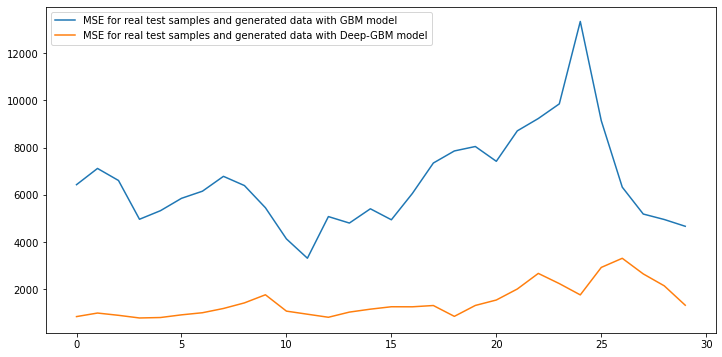

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(mse_gbm, label = 'MSE for real test samples and generated data with GBM model')
plt.plot(mse_deep_gbm, label = 'MSE for real test samples and generated data with Deep-GBM model')
plt.legend()

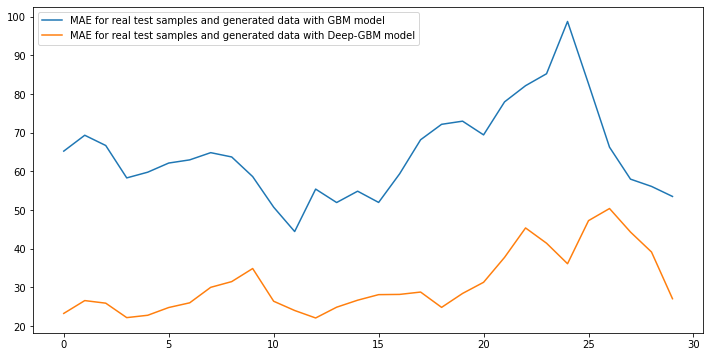

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(mae_gbm, label = 'MAE for real test samples and generated data with GBM model')
plt.plot(mae_deep_gbm, label = 'MAE for real test samples and generated data with Deep-GBM model')
plt.legend()

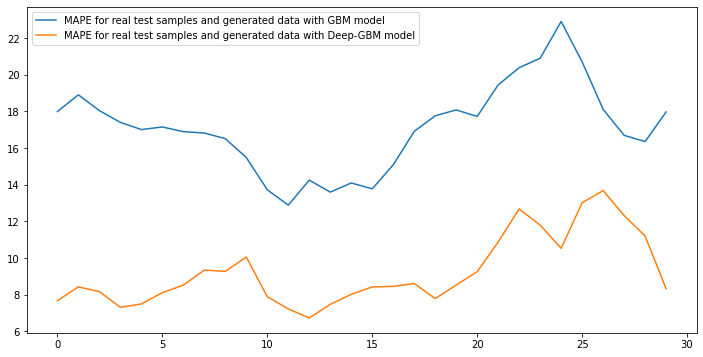

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(mape_gbm, label = 'MAPE for real test samples and generated data with GBM model')
plt.plot(mape_deep_gbm, label = 'MAPE for real test samples and generated data with Deep-GBM model')
plt.legend()